# ML Assignment 5 Part 1: Clusterwise Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Loading train and test datasets used in Assignment 1
train_df = pd.read_csv("germancredit_train_data.csv")
test_df = pd.read_csv("germancredit_test_data.csv")

In [ ]:
train_df.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,CheckingAccountStatus,CreditHistory,Purpose,Savings,EmploymentStatus,PersonalStatus,OtherDebtors,PropertyStatus,InstallmentPlansStatus,HousingStatus,JobStatus
0,15,2326,2,4,27,1,1,1,1,2,2,9,2,1,2,0,2,0,1,2
1,15,1471,4,4,35,2,1,0,1,0,2,3,0,1,2,0,3,2,2,2
2,24,1935,4,4,31,2,1,0,1,2,2,9,0,3,0,0,0,2,1,2
3,15,5324,1,4,35,1,1,1,1,0,0,0,2,3,1,0,3,2,2,2
4,6,709,2,2,27,1,1,1,0,3,0,0,3,0,3,0,0,2,1,0


In [ ]:
train_df = train_df[["Duration","Amount","InstallmentRatePercentage","ResidenceDuration","Age","NumberExistingCredits","NumberPeopleMaintenance"]]
test_df = test_df[["Duration","Amount","InstallmentRatePercentage","ResidenceDuration","Age","NumberExistingCredits","NumberPeopleMaintenance"]]

# Training the model using clustreg

In [ ]:
def clustreg(train_df, k, tries, seed, niter):

  # Set random seed
  np.random.seed(seed)

  y_train = train_df["Amount"]
  X_train = train_df.drop(columns=["Amount"])

  best_rsq = 0
  best_l = None
  best_c = None
  best_yhat = None
  best_models = []

  for l in range(tries):
    # Sample cluster assignments
    cluster_assignments = KMeans(n_clusters=k, random_state=l).fit_predict(X_train)
    cluster_assignments = pd.Series(cluster_assignments, index=X_train.index)

    for i in range(niter):
      # Initialize residuals and predictions matrices
      residuals = np.zeros((X_train.shape[0], k))
      predictions = np.zeros((X_train.shape[0], k))

      # Fit linear models for each cluster
      for j in range(k):
        cluster_data_X = X_train[cluster_assignments == j]
        cluster_data_y = y_train[cluster_assignments == j]
        model = LinearRegression().fit(cluster_data_X, cluster_data_y)
        predictions[:, j] = model.predict(X_train)
        residuals[:, j] = (predictions[:, j] - y_train) ** 2

      # Reassign data points to clusters based on minimum residuals
      cluster_assignments = pd.Series(np.argmin(residuals, axis=1), index=X_train.index)

      # Calculate predicted values for the current iteration
      yhat = predictions[np.arange(len(y_train)), cluster_assignments.values]

      # Calculate R-squared
      rsq = pearsonr(y_train, yhat)[0] ** 2
      if rsq > best_rsq:
        best_rsq = rsq
        best_c = cluster_assignments.copy()
        best_yhat = yhat.copy()
        best_l = l

        # Fit linear models for each cluster in the best solution
        best_models = []
        for j in range(k):
          cluster_X = X_train[best_c == j]
          cluster_y = y_train[best_c == j]
          model = LinearRegression().fit(cluster_X, cluster_y)
          best_models.append(model)

  # Create results list
  coefficients = []
  for i in range(k):
   coefficients.append(best_models[i].coef_)
   coefficients.append(best_models[i].intercept_)

  # Return results dictionary
  return {
      "nclust": k,
      "rsq.best": best_rsq,
      "cluster": best_c,
      "Coefficients": coefficients,
      "Models": best_models
  }

In [ ]:
res = []
r_sqds_train = []

for i in range(1,4):
    tmp = clustreg(train_df, i, 100, 7, 100)
    tmp_r2_train = tmp.get("rsq.best", 0)
    res.append(tmp)
    r_sqds_train.append(tmp_r2_train)

In [ ]:
print("Coefficients K = 1:", res[0]["Coefficients"])
print("Coefficients K = 2:", res[1]["Coefficients"])
print("Coefficients K = 3:", res[2]["Coefficients"])
print("R Squareds Test:", r_sqds_train)

Coefficients K = 1: [array([ 163.18543546, -864.02954979,  -30.91388342,   18.48191119,
        186.21052499,  154.04294507]), 1516.9179968544238]
Coefficients K = 2: [array([ 1.08300400e+02, -5.29776025e+02,  1.55852013e+01,  4.17251255e-01,
       -5.97529896e+01, -5.12618362e+01]), 1957.0765097861033, array([  179.72451511,  -615.69611673,   527.51084376,   -39.53142229,
       -1110.94293062,  -517.46809126]), 7376.851346986125]
Coefficients K = 3: [array([ 150.50895466, -423.05610483, -240.74867452,   54.25084776,
        525.73467168, 2171.96598905]), -1127.1658632128574, array([  91.39900619, -379.42678248,  -79.79812983,    8.30642829,
         70.49960912,  281.65146287]), 988.0252296979454, array([  155.09832387,   -87.14189467,   458.68217873,   -73.64339856,
       -3069.53749801, -1567.05263821]), 14007.743840600458]
R Squareds Test: [0.5124715101985235, 0.8381910330984758, 0.9153823132978582]


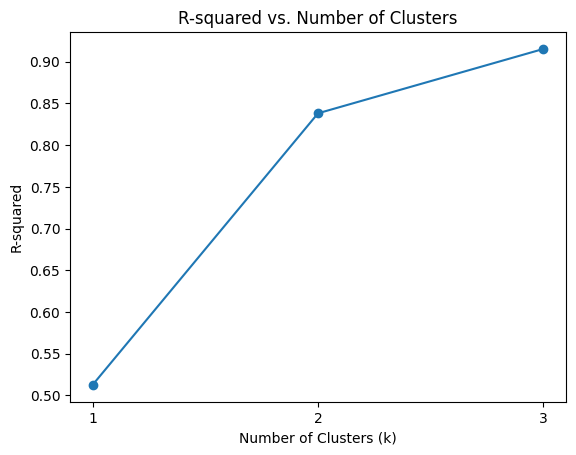

In [ ]:
# Plot Train R^2
ks = [1, 2, 3]
plt.plot(ks, r_sqds_train, marker='o', linestyle='-')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("R-squared")
plt.title("R-squared vs. Number of Clusters")
plt.xticks(ks)

plt.show()

We expect the R squared to improve with increase in clusters since the data points are assigned to the clusters based on the minimum residual for each linear regression model. K = 3 has the best R squared for train.

# Testing using clustreg_predict

In [ ]:
def clustreg_predict(results, newdat):

  # Extract necessary information from results
  coefs = results["Coefficients"]
  nclust = results["nclust"]
  best_models = results["Models"]


  # Initialize predictions and residuals matrices
  yhat = np.zeros(newdat.shape[0])
  resid = np.zeros((newdat.shape[0], nclust))
  pred = np.zeros((newdat.shape[0], nclust))

  # Predict for each cluster
  for j, model in enumerate(best_models):
    # Extract data for the current cluster
    y = newdat["Amount"]
    X = newdat.drop(columns=["Amount"])

    # Create a LinearRegression object from the model summary
    #for in in 1:nclust {

    #}

    # Predict for new data
    pred[:, j] = model.predict(X)

    # Compute residuals
    resid[:, j] = (pred[:, j] - y) ** 2

  # Assign new data points to clusters based on minimum residuals
  c = np.argmin(resid, axis=1)

  # Calculate predicted values for new data
  for m in range(newdat.shape[0]):
    yhat[m] = pred[m, c[m]]

  # Calculate R-squared
  rsq = pearsonr(newdat.iloc[:, 0], yhat)[0] ** 2

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(newdat["Amount"], yhat))

  # Return results dictionary
  return {
      "results": results,
      "newdata": newdat,
      "cluster": c,
      "yhat": yhat,
      "rsq": rsq,
      "rmse": rmse
  }

In [ ]:
test_res = []
r_sqds_test = []
rmse_test = []

for i in range(1,4):
    res_k = res[i - 1]
    tmp = clustreg_predict(res_k, test_df)
    tmp_r2_test = tmp.get("rsq", 0)
    test_res.append(tmp)
    r_sqds_test.append(tmp_r2_test)
    rmse_test.append(tmp.get("rmse", 0))

print("R Squareds Test:", r_sqds_test)
print("RMSE Test:", rmse_test)

R Squareds Test: [0.7809408968778812, 0.45712975427326497, 0.4218718080561319]
RMSE Test: [1816.604846707868, 1204.4378878123719, 994.6171888563825]


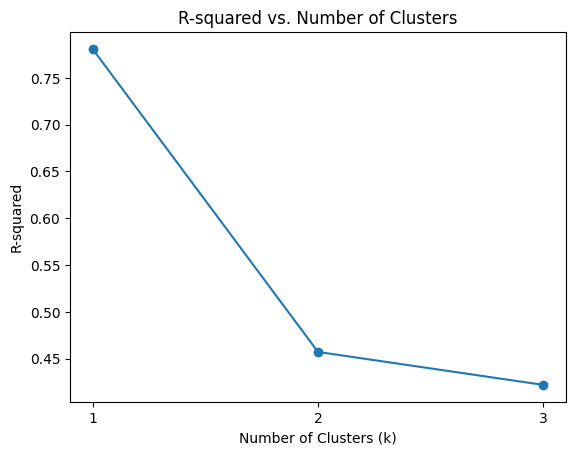

In [ ]:
# Plot Train R^2
ks = [1, 2, 3]
plt.plot(ks, r_sqds_test, marker='o', linestyle='-')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("R-squared")
plt.title("R-squared vs. Number of Clusters")
plt.xticks(ks)

plt.show()

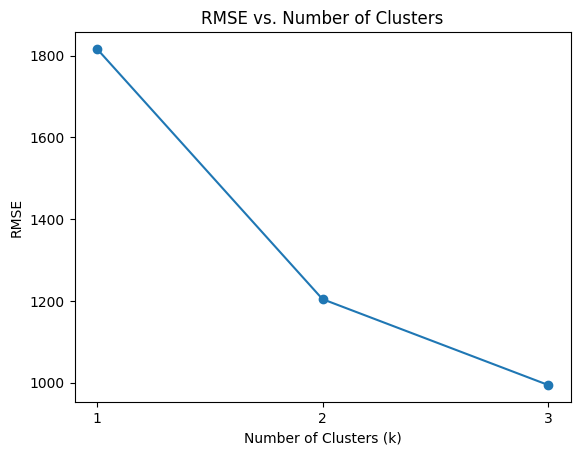

In [ ]:
# Plot Train R^2
ks = [1, 2, 3]
plt.plot(ks, rmse_test, marker='o', linestyle='-')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Number of Clusters")
plt.xticks(ks)

plt.show()

The decrease in R-squared as the number of clusters increases, compared to the increase seen in the training data, suggests potential overfitting. As the number of clusters grows, the model becomes overly fit to the training data, especially since data points are assigned to clusters based on the lowest residuals from the linear regression models. This improves prediction accuracy, as seen in the RMSE, but reduces the model's ability to explain the variance in the test data (lower R-squared). K=1 has the best R-squared for the test, while K = 3 has the lowest RMSE, indicating that while more clusters can improve performance, they can also harm the model's generalization to new data.

## Summary

Since all of the models have the same difficulty degree of interpreting the coefficients, we can determine the best model by evaluating R squared and RMSE.
Based on this, the best model is K = 3. Although it has the lowest R squared for the testing, it has the best RMSE on testing data for all K and has the highest R squared on the training data. For K = 1, the RMSE is twice as high as K = 3, therefore, we choose K = 3 as the best model. We find that this model has an R squared of 0.92 on train which is considerably strong, an RMSE of 994.63 on test, and an R squared of 0.42 on test which is somewhat low but could potentially be improved using cross-validation to reduce overfitting.

Characterizing the clusters:

* Cluster 0: Duration, Age, existing credits, and maintenance responsibilities increase the Amount, while installment rate and residence duration decrease it. The intercept suggests that the baseline Amount is around -1127.17 when all predictors are set to 0.
* Cluster 1: Duration, Age, existing credits, and maintenance responsibilities increase the Amount, while installment rate and residence duration decrease it. The intercept suggests a baseline Amount of approximately 988.03 when all predictors are 0. This cluster's model reflects similar relationships with cluster 0's model but with smaller effect sizes for each factor.
* Cluster 2: Duration, residence duration, and existing credits increase the Amount, while Age, installment rate, and maintenance responsibilities decrease it. The intercept indicates the baseline Amount is about 14007.74, suggesting a much higher baseline Amount compared to Clusters 0 and 1 when all predictors are 0.


Cluster Profiles:

* Cluster 0: Likely individuals with high debts or financial responsibilities, who might not yet have accumulated sufficient financial assets to offset liabilities. However, they have the potential to increase their financial capacity with time and better credit practices.

* Cluster 1: Likely individuals who have a moderate amount of credit history, age, and existing credits. These individuals also have some maintenance responsibilities, but their debt loads (installment rates) and residence duration may be more manageable compared to Cluster 0. Overall, they tend to be less affected by extreme values in the predictors.

* Cluster 2: Likely individuals who have longer credit histories, a longer time in their current residence, and more existing credit lines. These individuals may be older and have fewer financial obligations (lower installment rates). Their higher baseline amount suggests that they are in a group that may be able to secure larger loans or have a higher financial capacity overall.
